In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import shap

# 1 - Data Preprocessing

In [29]:
def processar_dados_ano(caminho_arquivo, escolas_comuns):
    df = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
    df = df[df['CO_ENTIDADE'].isin(escolas_comuns)]
    colunas_para_remover = [col for col in df.columns if (col.startswith('DS_') or col.startswith('NU_') or col.startswith('DT_') or col.startswith('CO_') or col.startswith('NO_')) and col != 'NU_ANO_CENSO']
    df_limpo = df.drop(columns=colunas_para_remover).drop(columns=['SG_UF'])
    colunas_com_nan = df_limpo.columns[df_limpo.isnull().any()].tolist()
    return df_limpo, colunas_com_nan

# Diretório e inicialização
diretorio = 'dataset/'
primeiro_ano = 2012
caminho_arquivo = f'{diretorio}microdados_ed_basica_{primeiro_ano}_alagoas.csv'
df_primeiro_ano = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
escolas_comuns = set(df_primeiro_ano['CO_ENTIDADE'].unique())

# Identificar escolas comuns em todos os anos
for ano in range(primeiro_ano + 1, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df = pd.read_csv(caminho_arquivo, encoding='latin1', delimiter=';')
    escolas_comuns = escolas_comuns.intersection(set(df['CO_ENTIDADE'].unique()))

# Lista para armazenar DataFrames de cada ano
dfs = [] 
matriculas_por_ano = []
docentes_por_ano = []
turmas_por_ano = []
brancas_por_ano = []
pardas_por_ano = []
diurno_por_ano = []
noturno_por_ano = []
masculino_por_ano = []
feminino_por_ano = []
anos = range(primeiro_ano, 2022)

# Processar dados de cada ano
for ano in anos:
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df_limpo, colunas_com_nan = processar_dados_ano(caminho_arquivo, escolas_comuns)
    dfs.append(df_limpo)
    
    # Somar o número de matrículas para o ano
    total_matriculas = df_limpo['QT_MAT_BAS'].sum()
    doc_por_ano = df_limpo['QT_DOC_BAS'].sum()
    tur_por_ano = df_limpo['QT_TUR_BAS'].sum()
    bra_por_ano = df_limpo['QT_MAT_BAS_BRANCA'].sum()
    pra_por_ano = df_limpo['QT_MAT_BAS_PARDA'].sum()
    d_por_ano = df_limpo['QT_MAT_BAS_D'].sum()
    n_por_ano = df_limpo['QT_MAT_BAS_N'].sum()
    fem_por_ano = df_limpo['QT_MAT_BAS_FEM'].sum()
    mas_por_ano = df_limpo['QT_MAT_BAS_MASC'].sum()

    
    matriculas_por_ano.append(total_matriculas)
    docentes_por_ano.append(doc_por_ano)
    turmas_por_ano.append(tur_por_ano)
    brancas_por_ano.append(bra_por_ano)
    pardas_por_ano.append(pra_por_ano)
    diurno_por_ano.append(d_por_ano)
    noturno_por_ano.append(n_por_ano)    
    feminino_por_ano.append(fem_por_ano)
    masculino_por_ano.append(mas_por_ano)

    
    print(f"Resumo dos dados de {ano}:")
    print(colunas_com_nan)
    print("--------------------------------------------------------------------\n")
    print(df_limpo.describe())

df_consolidado = pd.concat(dfs, ignore_index=True)

Resumo dos dados de 2012:
[]
--------------------------------------------------------------------

       NU_ANO_CENSO  TP_DEPENDENCIA  TP_CATEGORIA_ESCOLA_PRIVADA  \
count        2838.0     2838.000000                  2838.000000   
mean         2012.0        2.984144                     0.132135   
std             0.0        0.479501                     0.476981   
min          2012.0        1.000000                     0.000000   
25%          2012.0        3.000000                     0.000000   
50%          2012.0        3.000000                     0.000000   
75%          2012.0        3.000000                     0.000000   
max          2012.0        4.000000                     4.000000   

       TP_LOCALIZACAO  TP_LOCALIZACAO_DIFERENCIADA  TP_SITUACAO_FUNCIONAMENTO  \
count     2838.000000                  2838.000000                2838.000000   
mean         1.523256                     0.071529                   1.036998   
std          0.499547                     0.4

In [30]:
dados_ano = {'NU_ANO_CENSO': list(anos), 'QT_MAT_BAS': matriculas_por_ano, 'QT_DOC_BAS': doc_por_ano,'QT_TUR_BAS': turmas_por_ano, 'QT_MAT_BAS_BRANCA': brancas_por_ano, 'QT_MAT_BAS_PARDA': pardas_por_ano, 'QT_MAT_BAS_D': diurno_por_ano, 'QT_MAT_BAS_N': noturno_por_ano, 'QT_MAT_BAS_FEM': feminino_por_ano, 'QT_MAT_BAS_MASC': masculino_por_ano}
df_consolidado = pd.DataFrame(dados_ano)

In [31]:
def criar_janelas(sequencia, janela_tamanho):
    X, y = [], []
    for i in range(len(sequencia) - janela_tamanho):
        X.append(sequencia[i:(i + janela_tamanho)])
        y.append(sequencia[i + janela_tamanho, 0]) 
    return np.array(X), np.array(y)

In [32]:
dados = df_consolidado[['QT_MAT_BAS','QT_DOC_BAS','QT_TUR_BAS','QT_MAT_BAS_BRANCA','QT_MAT_BAS_PARDA','QT_MAT_BAS_D','QT_MAT_BAS_N','QT_MAT_BAS_FEM','QT_MAT_BAS_MASC']].values

scaler = MinMaxScaler(feature_range=(0, 1))
dados_escalados = scaler.fit_transform(dados)

janela_tamanho = 3
X, y = criar_janelas(dados_escalados, janela_tamanho)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 2 - Training the Model

In [33]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test, y_test))


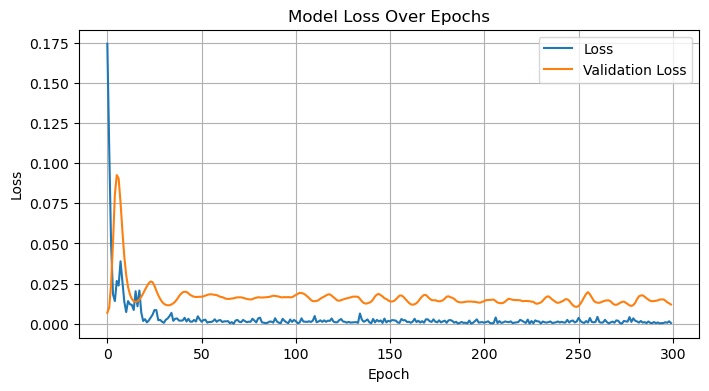

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict_rescaled = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], dados_escalados.shape[1] - 1))], axis=-1))[:, 0]
test_predict_rescaled = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], dados_escalados.shape[1] - 1))], axis=-1))[:, 0]

train_index = list(range(janela_tamanho, split + janela_tamanho))
test_index = list(range(split + janela_tamanho, len(df_consolidado)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


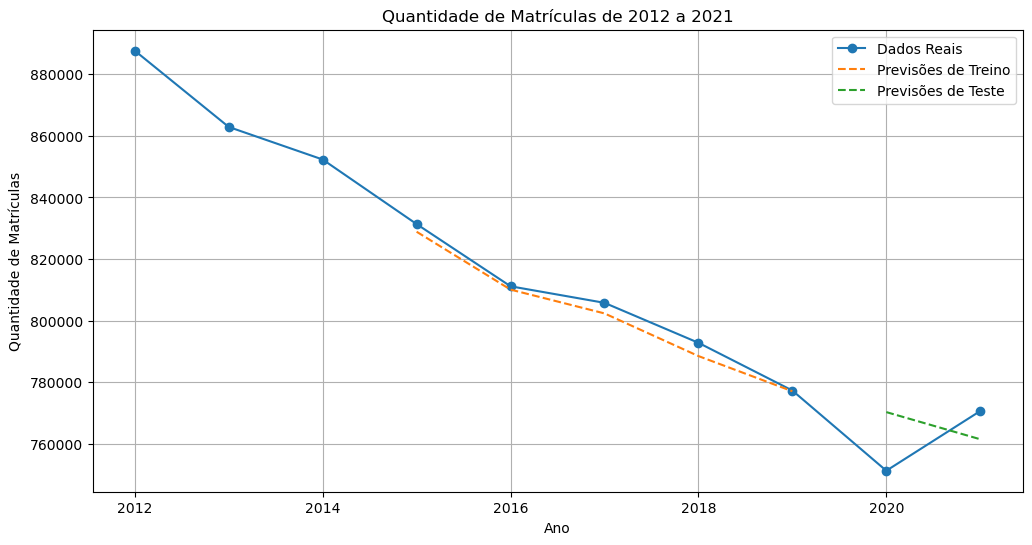

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df_consolidado['NU_ANO_CENSO'], df_consolidado['QT_MAT_BAS'], label='Dados Reais', marker='o')
plt.plot(df_consolidado['NU_ANO_CENSO'][train_index], train_predict_rescaled, label='Previsões de Treino', linestyle='--')
plt.plot(df_consolidado['NU_ANO_CENSO'][test_index], test_predict_rescaled, label='Previsões de Teste', linestyle='--')
plt.title('Quantidade de Matrículas de 2012 a 2021')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Matrículas')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests

# Dados de exemplo: Substitua com seus dados reais
data = {
    'QT_MAT_BAS': matriculas_por_ano,  # Sua série alvo
    'QT_DOC_BAS': doc_por_ano,         # Outra variável
    'QT_TUR_BAS': turmas_por_ano,
    'QT_MAT_BAS_BRANCA': brancas_por_ano,
    'QT_MAT_BAS_PARDA': pardas_por_ano,
    'QT_MAT_BAS_D': diurno_por_ano,
    'QT_MAT_BAS_N': noturno_por_ano
}

# Converter para DataFrame
df = pd.DataFrame(data)

# Verificar e imprimir colunas constantes
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"Coluna constante encontrada: {column} - Valor: {df[column].iloc[0]}")

# Remover colunas constantes
df = df.loc[:, df.nunique() > 1]

# Verificar os dados após remoção
print("Dados após remoção de colunas constantes:")
print(df.head())

# Definir o número máximo de lags para testar
maxlag = 2
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """ Cria uma matriz de causalidade de Granger mostrando os valores-p para cada par de variáveis."""
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# Executar a função com o seu DataFrame
causation_matrix = grangers_causation_matrix(df, variables=df.columns, verbose=True)

# Exibir a matriz de causalidade de Granger
print(causation_matrix)


Coluna constante encontrada: QT_DOC_BAS - Valor: 37196
Dados após remoção de colunas constantes:
   QT_MAT_BAS  QT_TUR_BAS  QT_MAT_BAS_BRANCA  QT_MAT_BAS_PARDA  QT_MAT_BAS_D  \
0      887607       33023             101953            399134        340093   
1      862867       32782             106142            423136        327779   
2      852300       32715             107356            434541        700108   
3      831344       32077             106322            435033        687679   
4      811157       31495             105116            436472        681105   

   QT_MAT_BAS_N  
0        169309  
1        155547  
2        152192  
3        142343  
4        129429  
Y = QT_MAT_BAS, X = QT_MAT_BAS, P Values = [1.0, 1.0]
Y = QT_TUR_BAS, X = QT_MAT_BAS, P Values = [0.0, 0.0]
Y = QT_MAT_BAS_BRANCA, X = QT_MAT_BAS, P Values = [0.0, 0.2118]
Y = QT_MAT_BAS_PARDA, X = QT_MAT_BAS, P Values = [0.0768, 0.3738]
Y = QT_MAT_BAS_D, X = QT_MAT_BAS, P Values = [0.7208, 0.0]
Y = QT_MAT_BAS_N,

c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou